# Sistema de detección de enlaces spam

## Paso 1. Lectura del conjunto de datos

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [2]:
df['url'][2]

'https://briefingday.com/m/v4n3i4f3'

In [3]:
df['is_spam'].value_counts()

is_spam
False    2303
True      696
Name: count, dtype: int64

## Paso 2. Procesamiento de datos.

Se transforman las columna objetivo a tipo numerica.

Si es spam tiene valor de 1

Si no es spam tiene valor de 0


In [4]:
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == True else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [10]:
df['is_spam'].value_counts()

is_spam
0    2303
1     696
Name: count, dtype: int64

## Ver duplicados

In [5]:
df[df.duplicated()].sort_values(by = ["url"])

,url,is_spam
2090,http://gettheelevator.com/,1
1536,http://gettheelevator.com/,1
2954,http://gettheelevator.com/,1
2600,http://gettheelevator.com/editorial,1
2091,http://gettheelevator.com/editorial,1
...,...,...
1211,https://www.youtube.com/user/voxdotcom,1
1968,https://www.youtube.com/user/voxdotcom,1
2928,https://www.youtube.com/user/voxdotcom,1
2248,https://www.youtube.com/user/voxdotcom,1


In [6]:
print("Tamaño antes de eliminar duplicados", df.shape)
df = df.drop_duplicates()
df = df.reset_index(inplace = False, drop = True)

print(f"Tamaño después de eliminar duplicados {df.shape}")

Tamaño antes de eliminar duplicados (2999, 2)
Tamaño después de eliminar duplicados (2369, 2)


### Procesamiento del texto
- Se eliminan signos de puntuación
- Convertir texto a minúsculas
- Eliminar caracteres sueltos

Y retorna una lista de palabras para después continuar eliminando las stop words

In [7]:
import regex as re

def preprocess_text(text):

    text = re.sub(r'[^\w\s]', ' ', text) # 1. Reemplaza puntuación por espacio


    # # 2. Elimina todo lo que no sea letra o espacio
   # text = re.sub(r'[^a-z ]', " ", text)

  # Permitir letras y números. Reemplazar cualquier cosa que no sea letra, número o espacio.
    text = re.sub(r'[^a-zA-Z0-9 ]', " ", text)


    text = re.sub(r'\s+[a-zA-Z0-9]\s+', " ", text) # 3. Elimina letras o num sueltas (como "x" o "z")
   # text = re.sub(r'\^[a-zA-Z]\s+', " ", text) # 4. Intenta eliminar ciertos símbolos con letra (¿errores?)


    text = re.sub(r'\s+', " ", text.lower()) # 5. Todo a minúsculas y un solo espacio

    # Eliminar tags
 #   text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text) # 6.  eliminar tags HTML

    return text.split()

df["url"] = df["url"].apply(preprocess_text)
df.head()

,url,is_spam
0,"[https, briefingday, us8, list, manage, com, u...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v4n3i4f3]",1
3,"[https, briefingday, com, 20200618, commentform]",0
4,"[https, briefingday, com, fan]",1


### Stop Words y Lematización 



In [8]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

download("wordnet")
download("stopwords")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))  # mejor usar set para eficiencia

def lemmatize_text(words):
    # Lematizar
    tokens = [lemmatizer.lemmatize(word) for word in words]

    # Eliminar stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Eliminar palabras muy cortas
    tokens = [word for word in tokens if len(word) > 3]

    return tokens

# Aplicar al dataset 
df["url"] = df["url"].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday, v4n3i4f3]",1
3,"[http, briefingday, 20200618, commentform]",0
4,"[http, briefingday]",1


## Visualización de palabras más frecuentes

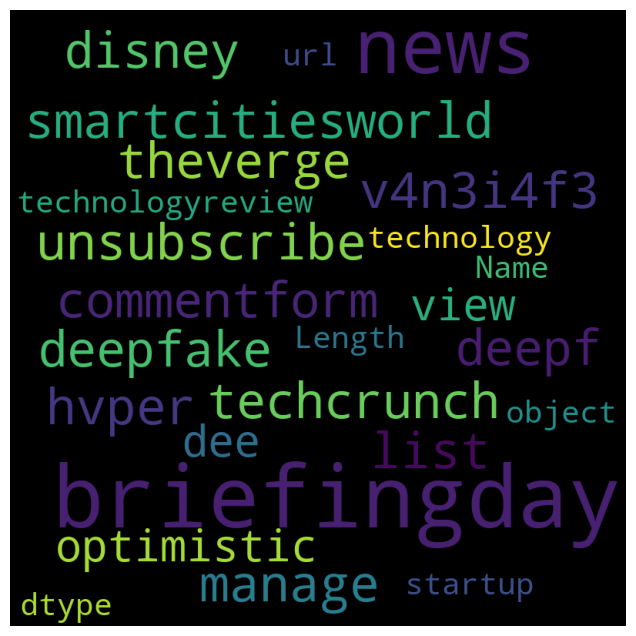

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Conversión de tokens en vectores y modelo SVM

In [9]:
df["tokens"] = df["url"]
# Unir los tokens en un solo string por fila (para TfidfVectorizer)
tokens_list = df["tokens"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

In [10]:
tokens_list

['http briefingday list manage unsubscribe',
 'http hvper',
 'http briefingday v4n3i4f3',
 'http briefingday 20200618 commentform',
 'http briefingday',
 'http brookings interactives reopening america world',
 'http reuters investigates special report health coronavirus britain',
 'http theatlantic magazine archive 2020 supermarket miracle 612244',
 'http 2020 21294680 john bolton book excerpt trump ukraine china',
 'http theguardian travel 2020 tourism coronavirus pandemic travel industry',
 'http future article 20200617 virus disappeared',
 'http narratively quarantined hippy trapped jungle paradise',
 'http ourworldindata grapher daily covid case average',
 'http spiked online 2020 healthy society destroy monument',
 'http nytimes interactive 2020 business economy container ship built html',
 'http aeon essay nostalgia rocket fuel power hope change',
 'http youtube watch k2wcu6agyz8 briefingday curator briefingday source briefingday medium email',
 'http popsci story science haribo 

### Tokenización 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,  # número máximo de palabras (dimensiones)
    max_df=0.8,         # ignorar palabras que aparecen en más del 80% de los textos
    min_df=5            # ignorar palabras que aparecen en menos de 5 textos
)

X = vectorizer.fit_transform(tokens_list).toarray()

In [12]:
y = df["is_spam"]

## Entrenamiento

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42, class_weight="balanced")
model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [15]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9029535864978903

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       435
           1       0.45      0.82      0.58        39

    accuracy                           0.90       474
   macro avg       0.72      0.87      0.76       474
weighted avg       0.94      0.90      0.92       474



Optimización de hiperparametros con grid search

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    scoring='f1',  # Por el desbalance
    cv=5,                # 5 particiones (cross-validation)
    verbose=2,
    n_jobs=-1            # Usar todos los núcleos disponibles
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, k

,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,10


In [19]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor puntuación (accuracy promedio en CV):")
print(grid_search.best_score_)

Mejores parámetros encontrados:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Mejor puntuación (accuracy promedio en CV):
0.6273534153639788


In [20]:
# Usar el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Predecimos en el conjunto de prueba
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print(" Reporte de clasificación final:")
print(classification_report(y_test, y_pred))

print(" Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

 Reporte de clasificación final:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       435
           1       0.76      0.67      0.71        39

    accuracy                           0.96       474
   macro avg       0.87      0.82      0.84       474
weighted avg       0.95      0.96      0.95       474

 Matriz de confusión:
[[427   8]
 [ 13  26]]


El modelo predijo :
- Verdaderos negativos: 427 Valores en no spam y eran url no spam
- Falsos negativos: 8 valores en no spam y eran spam, clasificó 8 valores como no spam cuando si lo son
- Falsos positivos: 13 valores los predijo  como  spam cuando no  son spam 
- Verdaderos positivos: 26 valores como  spam (uno) y si son spam


El desbalance de clases hace que el modelo sea propenso a predecir mas valores en ceo

In [29]:
import joblib

joblib.dump(best_model, 'mejor_modelo_svc.pkl')


['mejor_modelo_svc.pkl']